# Imports

In [3]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
import pandas as pd
from queue import PriorityQueue
from math import inf
import numpy as np


import osmnx as ox
ox.settings.log_console=True
ox.settings.use_cache=True

# Speed-Up-Techniken


## Example Setup

In [4]:
adress = "Weingartener Straße 2, Stutensee, Deutschland"
base_graph = ox.graph_from_address(adress, dist=20000, dist_type='bbox', network_type='drive') # 10000, 20000, 50000

In [5]:
orig_cords = ox.geocode("Weingartener Straße 2, Stutensee, Deutschland")
orig_node = ox.nearest_nodes(base_graph, orig_cords[1], orig_cords[0])

dest_cords = ox.geocode("Moltkestraße 30, Karlsruhe, Deutschland")
dest_node = ox.nearest_nodes(base_graph, dest_cords[1], dest_cords[0]) 

## Dijkstra mit Routenziel

In [43]:
def backtrace(prev, start, end):
    node = end
    path = []
    while node != start:
        path.append(node)
        node = prev[node]
    path.append(node) 
    path.reverse()
    return path

In [45]:
# Basic Dijkstra 
def dijkstra(graph, start, end):

    #Initialisierung
    pred_node = {} 
    dist = {v: inf for v in list(nx.nodes(graph))} 
    dist[start] = 0    
    visited = set()
    priority_queue = PriorityQueue()  
    priority_queue.put((dist[start], start))
    current_node = start

    # Solange die aktuelle Node nicht der Zielknow ist, tue:
    while current_node != end:  
        current_node_cost, current_node = priority_queue.get()
        visited.add(current_node)

        for neighbor in dict(graph.adjacency()).get(current_node):
            path = dist[current_node] + graph.get_edge_data(current_node,neighbor).get('length')

            if path < dist[neighbor]:
                dist[neighbor] = path
                pred_node[neighbor] = current_node
                if neighbor not in visited:
                    priority_queue.put((dist[neighbor], neighbor))
                else:
                    remove = priority_queue.get((dist[neighbor], neighbor))
                    priority_queue.put((dist[neighbor], neighbor))

        
    print(f"Distance: {dist[end]}" )
    print(f"Visited: {len(visited)}")
    return backtrace(pred_node, start, end), dist[end], visited

In [46]:
di_graph = ox.utils_graph.get_digraph(base_graph, weight="length")

route, dist, visited = dijkstra(di_graph, orig_node, dest_node)

Distance: 16187.009000000005
Visited: 9474


In [47]:
ox.plot_route_folium(base_graph, route)

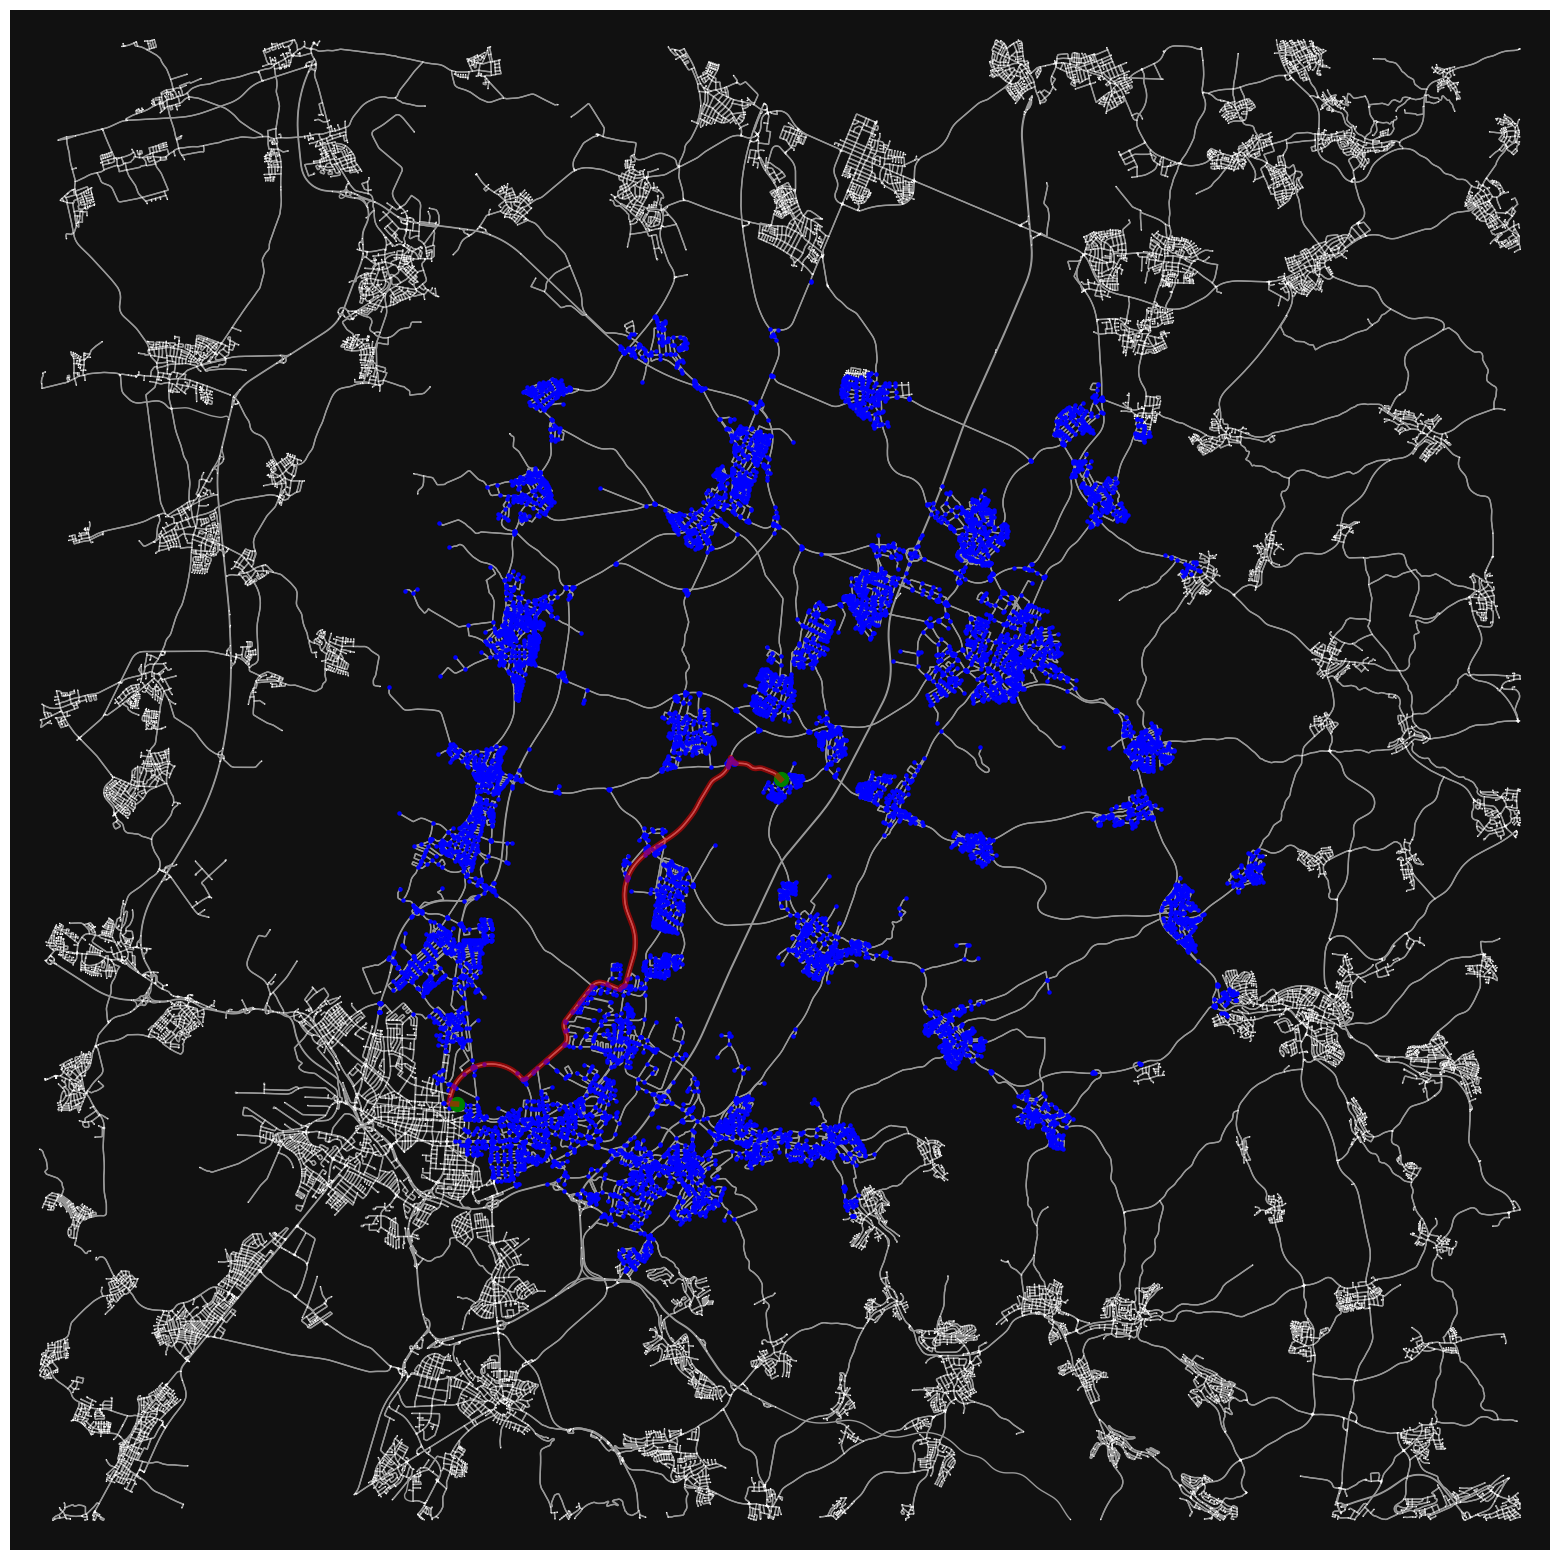

In [48]:
visited_list = list(visited)

fig, ax = ox.plot_graph_route(base_graph, route, route_color='r', node_size=1,
                        show=False, close=False, figsize=(20,20))
for node in visited_list:
    ax.scatter(base_graph.nodes[node]['x'], base_graph.nodes[node]['y'], c='b', s=5)

ax.scatter(base_graph.nodes[orig_node]['x'], base_graph.nodes[orig_node]['y'], c='g', s=100)
ax.scatter(base_graph.nodes[dest_node]['x'], base_graph.nodes[dest_node]['y'], c='g', s=100)

plt.show()

## Bidirectional Search
- Beschreibung:
    - Pseudcode
    - Eigenschaften (Heuristik?, Speed-Up)
    - Vergleich Suchradien (zu normalen Dijkstra) 
- Einfache Implementierung:
    - Gedanke: Dijkstra 2x
    - OSMNX liefert DiGraphen. Hier muss bei Suche ausgehend von Ziel darauf geachtet werden, dass Predecessors (anstellen von Successors verwendet werden.)

In [49]:
def bidirectional_backtrace(pred_node_source, pred_node_target, start, intersection , end):
    
    # From intersection to start
    node = intersection
    path = []
    while node != start:
        path.append(node)
        node = pred_node_source[node]
    path.append(node) 
    path.reverse()

    # From intersection to end
    node = intersection
    while node != end:
        if node != intersection:
            path.append(node)
        node = pred_node_target[node]
    path.append(node)

    return path

In [50]:
# Bidirectional Dijkstra 
def bidirectional_dijkstra(graph, start, end):

    # Initialisierung für Suche von beginnend bei Start und Suche beginnend bei Ziel
    pred_node_source = {}
    dist_source = {v: inf for v in list(nx.nodes(graph))} 
    dist_source[start] = 0
    visited_source = set()
    priority_queue_source = PriorityQueue()  
    priority_queue_source.put((dist_source[start], start))
    
    pred_node_target = {}
    dist_target = {v: inf for v in list(nx.nodes(graph))} 
    dist_target[end] = 0
    visited_target = set()
    priority_queue_target = PriorityQueue()  
    priority_queue_target.put((dist_target[end], end))

    
    # Solange keine Node bereits von beiden Richtungen besucht wurde, tue:
    while len(visited_source.intersection(visited_target)) == 0:
        
        # Source: Nachfolger der aktuellen Node abrufen und für jeden Nachfolger die Distanz berechnen
        current_node_source_cost, current_source_node = priority_queue_source.get()
        visited_source.add(current_source_node)
        for neighbor in dict(graph.adjacency()).get(current_source_node):
            path = dist_source[current_source_node] + graph.get_edge_data(current_source_node, neighbor).get('length')

            if path < dist_source[neighbor]:
                dist_source[neighbor] = path
                pred_node_source[neighbor] = current_source_node
                if neighbor not in visited_source:
                    priority_queue_source.put((dist_source[neighbor], neighbor))
                else:
                    _ = priority_queue_source.get((dist_source[neighbor], neighbor))
                    priority_queue_source.put((dist_source[neighbor], neighbor))


        # Target: Nachfolger der aktuellen Node abrufen und für jeden Nachfolger die Distanz berechnen
        current_node_target_cost, current_target_node = priority_queue_target.get()
        visited_target.add(current_target_node)
        for neighbor in graph.predecessors(current_target_node):
            path = dist_target[current_target_node] + graph.get_edge_data(neighbor, current_target_node).get('length')

            if path < dist_target[neighbor]:
                dist_target[neighbor] = path
                pred_node_target[neighbor] = current_target_node
                if neighbor not in visited_target:
                    priority_queue_target.put((dist_target[neighbor], neighbor))
                else:
                    _ = priority_queue_target.get((dist_target[neighbor], neighbor))
                    priority_queue_target.put((dist_target[neighbor], neighbor))
    

    print(f"Visited Forward Search: {len(visited_source)}")
    print(f"Visited Backwards Search: {len(visited_target)}")
    intersection = visited_source.intersection(visited_target).pop()
    print(f"Intersection: {intersection}")
    print(f"Distance: {dist_target[intersection] + dist_source[intersection]}")
    return bidirectional_backtrace(pred_node_source, pred_node_target, start, intersection, end), dist_target[intersection] + dist_source[intersection], visited_source, visited_target

In [51]:
di_graph = ox.utils_graph.get_digraph(base_graph, weight="length")

route_bi, dist, visited_source, visited_target = bidirectional_dijkstra(di_graph, orig_node, dest_node)

Visited Forward Search: 3595
Visited Backwards Search: 3557
Intersection: 21733389
Distance: 16187.009000000002


In [52]:
ox.plot_route_folium(base_graph, route_bi)

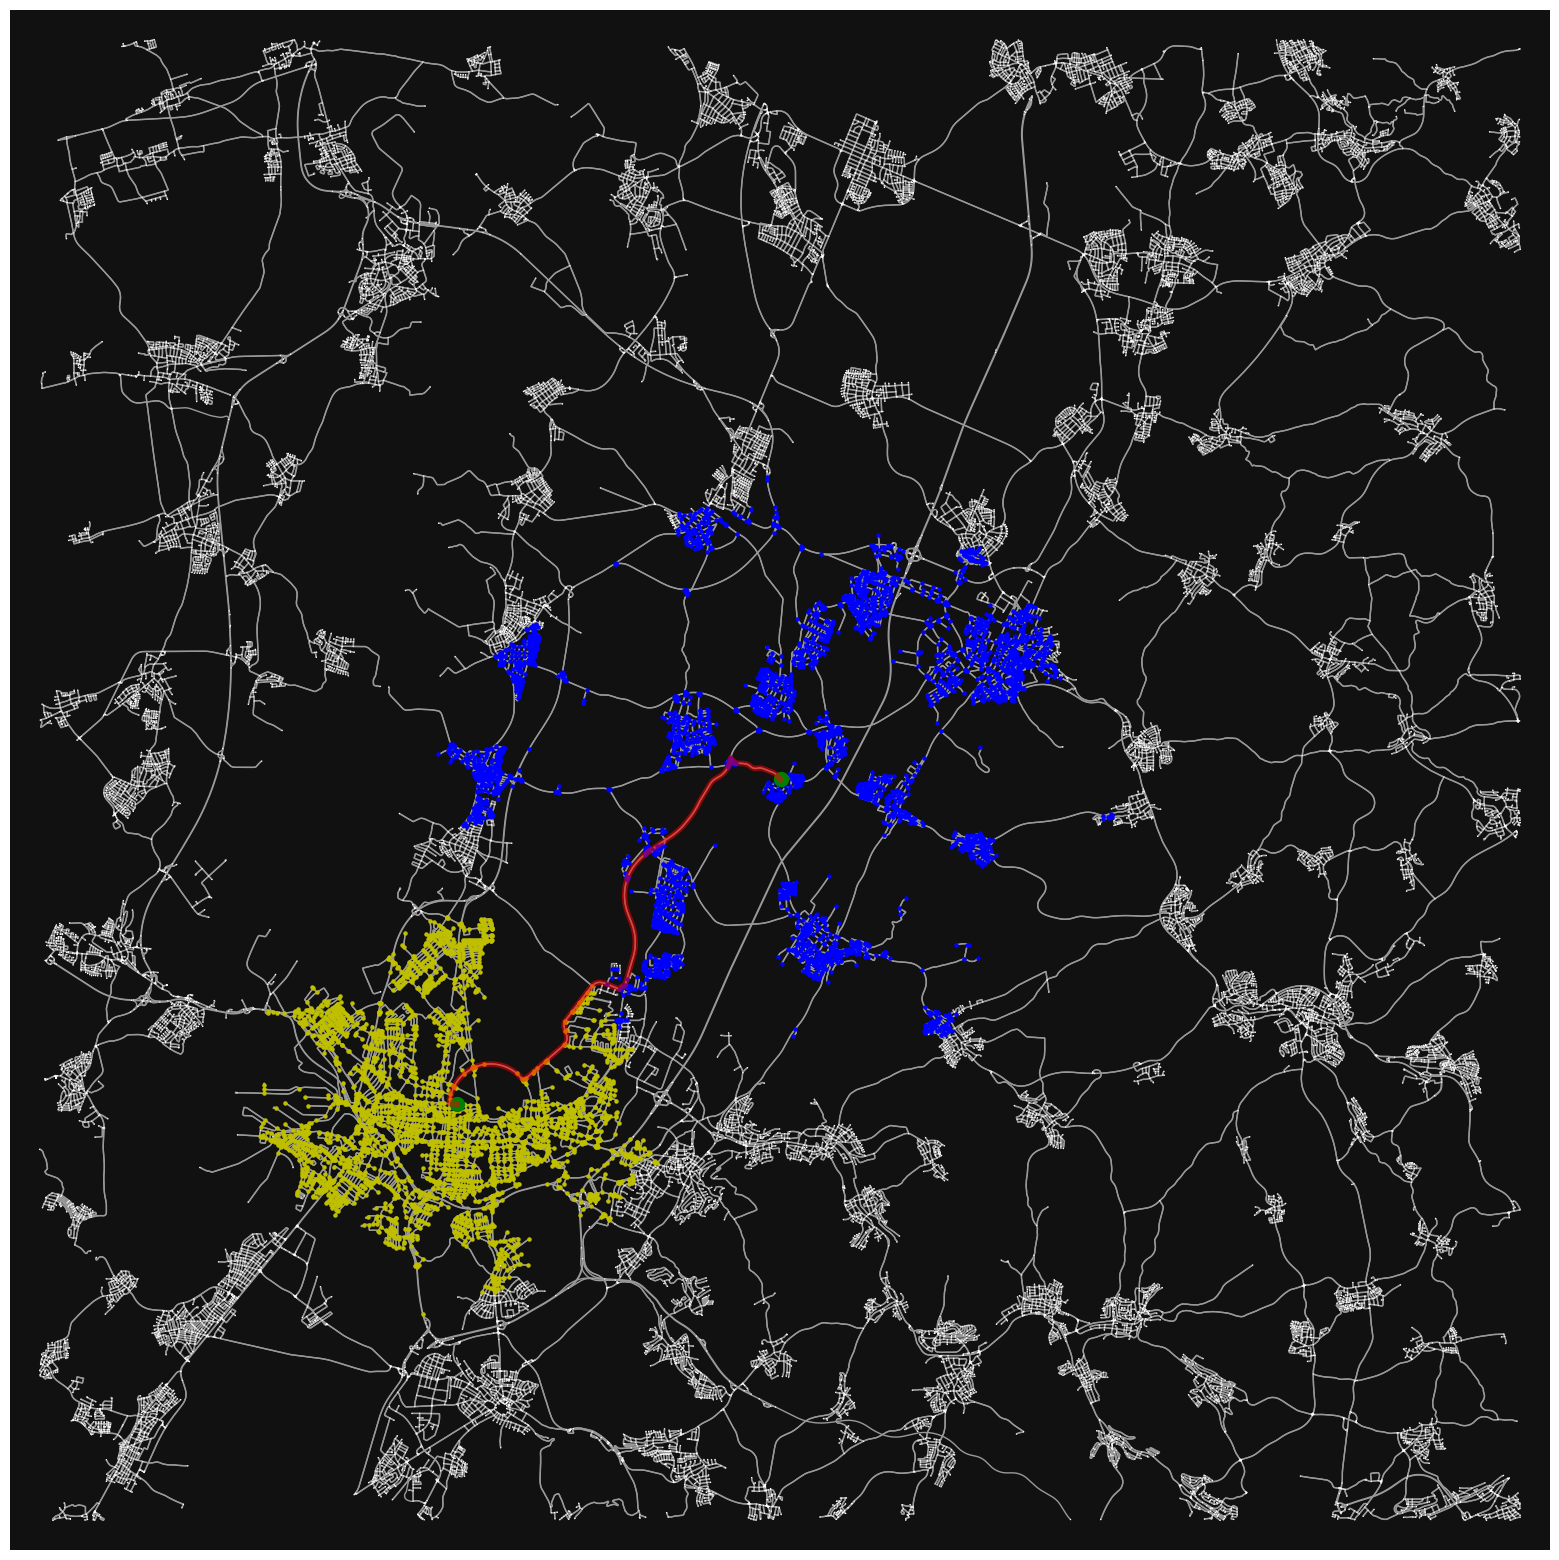

In [42]:
visited_list_source = list(visited_source)
visited_list_target = list(visited_target)

#plot base graph
fig, ax = ox.plot_graph_route(base_graph, route_bi, route_color='r', node_size=1,
                        show=False, close=False, figsize=(20,20))

# visited points are red
for node in visited_list_source:
    ax.scatter(base_graph.nodes[node]['x'], base_graph.nodes[node]['y'], c='b', s=5)

# visited points are red
for node in visited_list_target:
    ax.scatter(base_graph.nodes[node]['x'], base_graph.nodes[node]['y'], c='y', s=5)

ax.scatter(base_graph.nodes[orig_node]['x'], base_graph.nodes[orig_node]['y'], c='g', s=100)
ax.scatter(base_graph.nodes[dest_node]['x'], base_graph.nodes[dest_node]['y'], c='g', s=100)


plt.show()

## Leveling
- Idee: Mit dem Multi-Level Ansatz können hierarchische Beziehungen in den Netzwerken genutzt werden, um den Suchraum für den kürzesten Weg zu reduzieren. So könnten z.B. in größerer Entfernung von Start und Ziel nur "wichtige" Straßen, wie z.B. Autobahnen oder Bundesstraßen betrachtet werden, da diese meist am schnellsten sind. In der Nähe von Start und Ziel müssen alle Straßen untersucht werden.
- Umsetzung: Nutzen der Einstufung von Straßen in Open-Street-Map, Je weiter weg, desto höher muss die Stufe sein, um in den Suchraum aufgenommen zu werden.
- Weitere Verfeinerungen für Heuristik: Algorithmus für Cliques, Algorithmen für Skeleton

In [10]:
adress = "Weingartener Straße 2, Stutensee, Deutschland"
detail_source_graph = ox.graph_from_address(adress, dist=5000, dist_type='bbox', network_type='drive') # 10000, 20000, 50000

In [11]:
adress = "Moltkestraße 30, Karlsruhe, Deutschland"
detail_target_graph = ox.graph_from_address(adress, dist=5000, dist_type='bbox', network_type='drive') # 10000, 20000, 50000

Sparse base graph with only important roads
- Explain OSM Classification

In [12]:
# Dict with Road-Classification
cf =  '["highway"~"motorway|trunk|primary|secondary|tertiary|motorway_link|trunk_link|primary_link|secondary_link|tertiary_link"]'

In [13]:
adress = "Weingartener Straße 2, Stutensee, Deutschland"
base_graph_sparse = ox.graph_from_address(adress, dist=20000, dist_type='bbox', network_type='drive', custom_filter=cf) # 10000, 20000, 50000

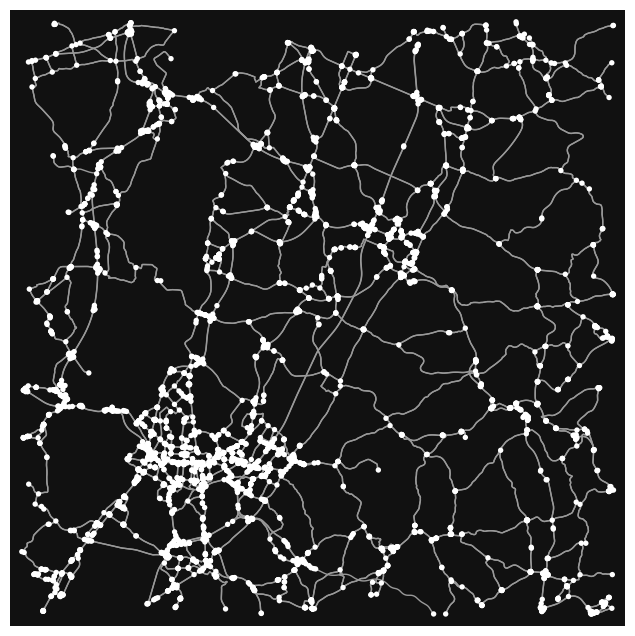

In [14]:
fig, ax = ox.plot_graph(base_graph_sparse)

In [15]:
print(len(base_graph.nodes()))
print(len(base_graph_sparse.nodes()))

28879
3864


In [16]:
base_nodes, base_edges = ox.graph_to_gdfs(base_graph_sparse, nodes=True, edges=True, node_geometry=True)
source_nodes, source_edges = ox.graph_to_gdfs(detail_source_graph, nodes=True, edges=True, node_geometry=True) #
target_nodes, target_edges = ox.graph_to_gdfs(detail_target_graph, nodes=True, edges=True, node_geometry=True) #

In [17]:
base_edges['osmid'].value_counts()

4679606                                                                      8
22912411                                                                     8
34965813                                                                     8
27432743                                                                     8
23769012                                                                     8
                                                                            ..
[117386461, 204804397, 204804383]                                            1
[366301602, 24719782, 385794023, 24719784, 24719785, 385794024, 84620369]    1
35008272                                                                     1
[366301602, 24719782, 385794023, 385794024, 24719785, 24719784, 84620369]    1
1126694675                                                                   1
Name: osmid, Length: 5638, dtype: int64

In [18]:
# Join all Geo Dataframes
leveling_edges = pd.concat([base_edges, source_edges, target_edges])
leveling_nodes = pd.concat([base_nodes, source_nodes, target_nodes])
# Remove duplicate nodes and edges
leveling_nodes = leveling_nodes[~leveling_nodes.index.duplicated(keep='first')]
leveling_edges = leveling_edges[~leveling_edges.index.duplicated(keep='first')]

In [19]:
leveling_graph = ox.graph_from_gdfs(leveling_nodes, leveling_edges, graph_attrs=None)

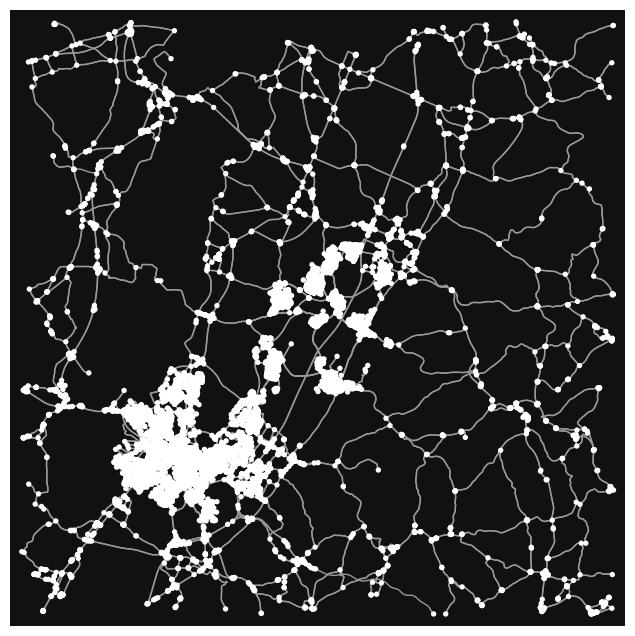

In [20]:
fig, ax = ox.plot_graph(leveling_graph)

In [21]:
print(f"Anzahl Knoten und Edges Base Graph: {len(base_graph.nodes())} nodes, {len(base_graph.edges())} edges")
print(f"Anzahl Knoten und Edges Sparse Base Graph: {len(leveling_graph.nodes())} nodes, {len(leveling_graph.edges())} edges")

Anzahl Knoten und Edges Base Graph: 28879 nodes, 70603 edges
Anzahl Knoten und Edges Sparse Base Graph: 8416 nodes, 19316 edges


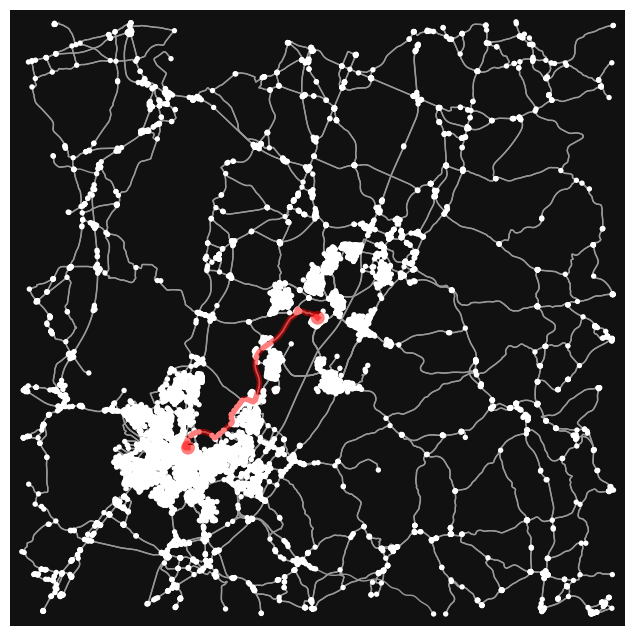

In [22]:
route = nx.dijkstra_path(G=leveling_graph, source=orig_node, target=dest_node, weight='length')
fig, ax = ox.plot_graph_route(leveling_graph, route, route_color='r')

## A-Star

In [23]:
di_graph = ox.utils_graph.get_digraph(base_graph, weight="length")
di_graph

In [24]:
# initializing points in
# numpy arrays
point1 = np.array((di_graph.nodes[dest_node]['y'], di_graph.nodes[dest_node]['x']))
point2 = np.array((di_graph.nodes[orig_node]['y'], di_graph.nodes[orig_node]['x']))
 
# calculating Euclidean distance
dist = np.linalg.norm(point1 - point2) * 100000
dist

14385.418595859692

In [25]:
def backtrace(prev, start, end):
    node = end
    path = []
    while node != start:
        path.append(node)
        node = prev[node]
    path.append(node) 
    path.reverse()
    return path

In [30]:
# A-Star Dijkstra 
def a_star_dijkstra(graph, start, end):

    #Initialisierung
    dest_point = np.array((graph.nodes[end]['y'], graph.nodes[end]['x']))

    pred_node = {} 
    dist = {v: inf for v in list(nx.nodes(graph))}
    dist[start] = 0
    visited = set() 
    priority_queue = PriorityQueue()  
    priority_queue.put((dist[start], start))
    current_node = start

    while current_node != end: 

        current_node_cost, current_node = priority_queue.get()
        visited.add(current_node)
        for neighbor in dict(graph.adjacency()).get(current_node):

            # Näherung der Luftlinie bis zu Zielknoten berechnen 
            neighbor_point = np.array((graph.nodes[neighbor]['y'], graph.nodes[neighbor]['x']))
            dist_to_end = np.linalg.norm(neighbor_point - dest_point)  * 100000

            # Näherung der Luftlinie bei Distanzberechnung einbeziehen
            # Knoten, die von dem Zielknoten weiter weg liegen, werden damit bestraft
            path = dist[current_node] + graph.get_edge_data(current_node,neighbor).get('length') + dist_to_end

            if path < dist[neighbor]:
                dist[neighbor] = path
                pred_node[neighbor] = current_node
                if neighbor not in visited:
                    priority_queue.put((dist[neighbor], neighbor))
                else:
                    remove = priority_queue.get((dist[neighbor], neighbor))
                    priority_queue.put((dist[neighbor], neighbor))

                    
    print(f"Distance: {dist[end]}" )
    print(f"Visited: {len(visited)}")
    return backtrace(pred_node, start, end), dist[end], visited

In [31]:
route, dist, visited = a_star_dijkstra(di_graph, orig_node, dest_node)

Distance: 350193.12802410504
Visited: 1869


In [144]:
ox.plot_route_folium(base_graph, route)

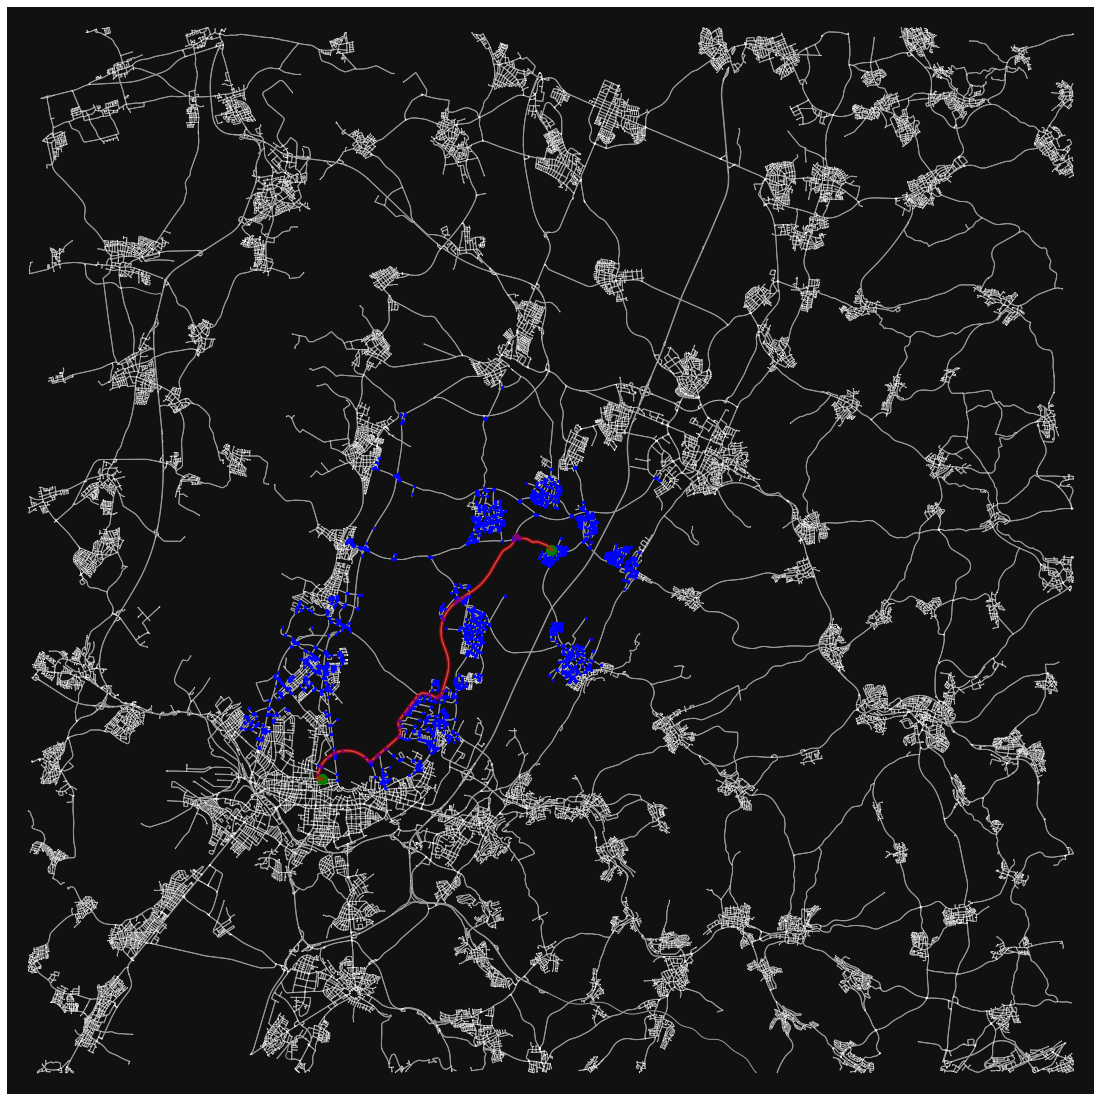

In [148]:
visited_list = list(visited)

#plot base graph
fig, ax = ox.plot_graph_route(base_graph, route, route_color='r', node_size=1,
                        show=False, close=False, figsize=(20,20))

# visited points are red
for node in visited_list:
    ax.scatter(base_graph.nodes[node]['x'], base_graph.nodes[node]['y'], c='b', s=5)

ax.scatter(base_graph.nodes[orig_node]['x'], base_graph.nodes[orig_node]['y'], c='g', s=100)
ax.scatter(base_graph.nodes[dest_node]['x'], base_graph.nodes[dest_node]['y'], c='g', s=100)


plt.show()

Bidirectional A-Start

In [153]:
# Bidirectional A-Star Dijkstra 
def bidirectional_a_star_dijkstra(graph, start, end):

    ## Initialisierung
    # Koordinaten des Start- und Endpunktes speichern für die Berechnung der Luftlinie
    dest_point = np.array((graph.nodes[end]['y'], graph.nodes[end]['x']))
    orig_point = np.array((graph.nodes[start]['y'], graph.nodes[start]['x']))

    pred_node_source = {}
    dist_source = {v: inf for v in list(nx.nodes(graph))} 
    dist_source[start] = 0
    visited_source = set() 
    priority_queue_source = PriorityQueue()  
    priority_queue_source.put((dist_source[start], start))

    pred_node_target = {}
    dist_target = {v: inf for v in list(nx.nodes(graph))} 
    dist_target[end] = 0
    visited_target = set() 
    priority_queue_target = PriorityQueue()  
    priority_queue_target.put((dist_target[end], end))

    while len(visited_source.intersection(visited_target)) == 0:
        
        # Vorwärtssuche: Nachfolger der aktuellen Node abrufen und für jeden Nachfolger die Distanz berechnen
        current_node_source_cost, current_source_node = priority_queue_source.get()
        visited_source.add(current_source_node)
        for neighbor in dict(graph.adjacency()).get(current_source_node):
            
            neighbor_point = np.array((graph.nodes[neighbor]['y'], graph.nodes[neighbor]['x']))
            dist_to_end = np.linalg.norm(neighbor_point - dest_point)  * 100000
            
            path = dist_source[current_source_node] + graph.get_edge_data(current_source_node, neighbor).get('length') + dist_to_end

            if path < dist_source[neighbor]:
                dist_source[neighbor] = path
                pred_node_source[neighbor] = current_source_node
                if neighbor not in visited_source:
                    priority_queue_source.put((dist_source[neighbor], neighbor))
                else:
                    _ = priority_queue_source.get((dist_source[neighbor], neighbor))
                    priority_queue_source.put((dist_source[neighbor], neighbor))

        # Rückwärtssuche: Vorgänger der aktuellen Node abrufen und für jeden Nachfolger die Distanz berechnen
        current_node_target_cost, current_target_node = priority_queue_target.get()
        visited_target.add(current_target_node)
        for neighbor in graph.predecessors(current_target_node):
            neighbor_point = np.array((graph.nodes[neighbor]['y'], graph.nodes[neighbor]['x']))
            dist_to_end = np.linalg.norm(neighbor_point - orig_point)  * 100000
            
            path = dist_target[current_target_node] + graph.get_edge_data(neighbor, current_target_node).get('length')

            if path < dist_target[neighbor]:
                dist_target[neighbor] = path
                pred_node_target[neighbor] = current_target_node
                if neighbor not in visited_target:
                    priority_queue_target.put((dist_target[neighbor], neighbor))
                else:
                    _ = priority_queue_target.get((dist_target[neighbor], neighbor))
                    priority_queue_target.put((dist_target[neighbor], neighbor))

    
    print(f"Visited Forward Search: {len(visited_source)}")
    print(f"Visited Backwards Search: {len(visited_target)}")
    intersection = visited_source.intersection(visited_target).pop()
    print(f"Intersection: {intersection}")
    print(f"Distance: {dist_target[intersection] + dist_source[intersection]}")
    return bidirectional_backtrace(pred_node_source, pred_node_target, start, intersection, end), dist_target[intersection] + dist_source[intersection], visited_source, visited_target

In [154]:
di_graph = ox.utils_graph.get_digraph(base_graph, weight="length")

route_bi, dist, visited = bidirectional_dijkstra(di_graph, orig_node, dest_node)

Visited Forward Search: 1377
Visited Backwards Search: 1260
Intersection: 14959936
Distance: 334773.6718273323


In [155]:
ox.plot_route_folium(base_graph, route_bi)

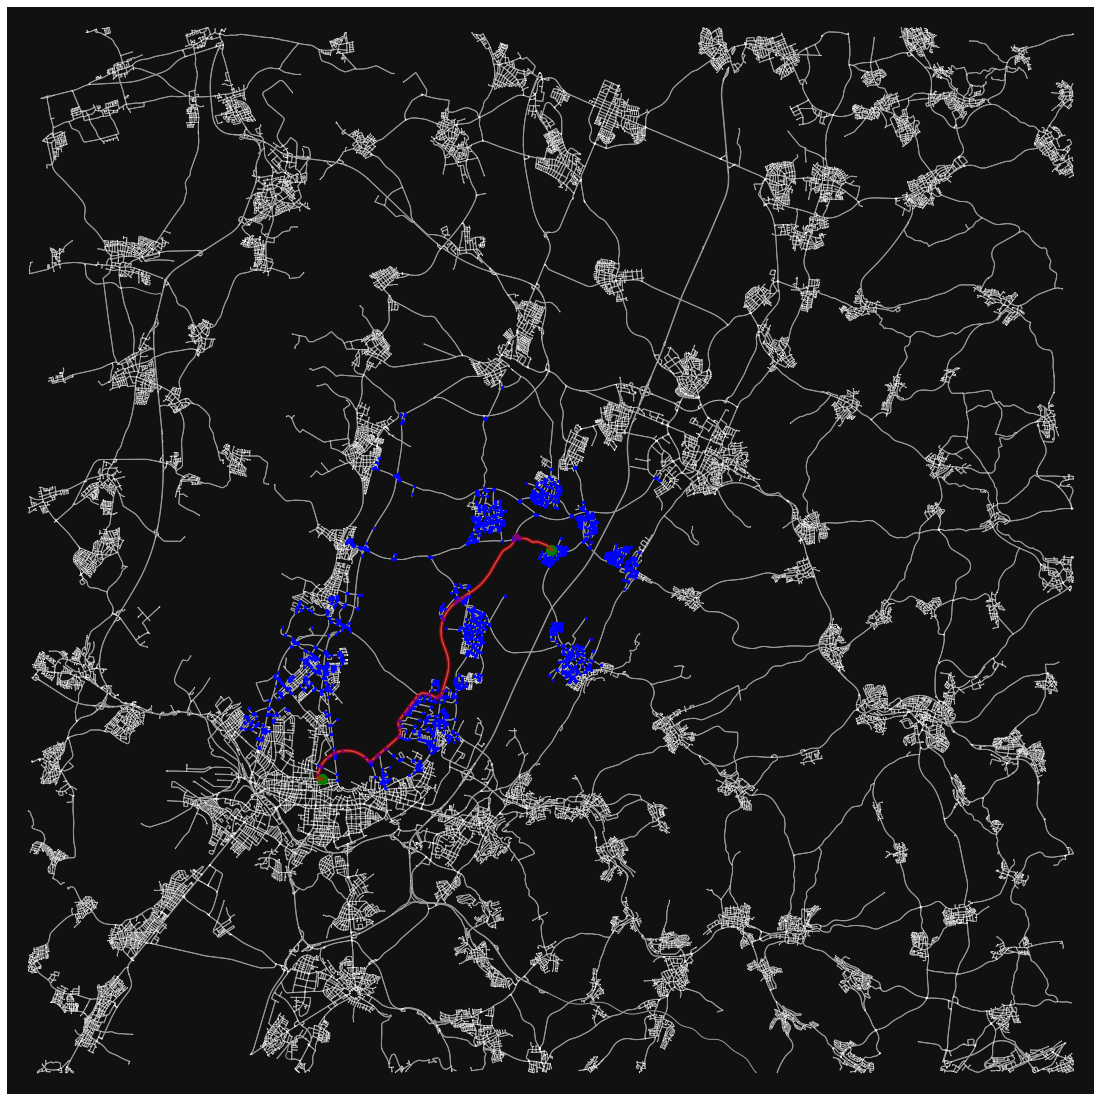

In [156]:
visited_list_source = list(visited_source)
visited_list_target = list(visited_target)
fig, ax = ox.plot_graph_route(base_graph, route_bi, route_color='r', node_size=1,
                        show=False, close=False, figsize=(20,20))

for node in visited_list_source:
    ax.scatter(base_graph.nodes[node]['x'], base_graph.nodes[node]['y'], c='b', s=5)
for node in visited_list_target:
    ax.scatter(base_graph.nodes[node]['x'], base_graph.nodes[node]['y'], c='y', s=5)

ax.scatter(base_graph.nodes[orig_node]['x'], base_graph.nodes[orig_node]['y'], c='g', s=100)
ax.scatter(base_graph.nodes[dest_node]['x'], base_graph.nodes[dest_node]['y'], c='g', s=100)

plt.show()